# Radial Bearing:

The objective of this notebook is to develop a method for experimentally characterizing the three-pole CRAMB such that we can relate currents to forces:

### Force model:

\begin{align}
\vec{F} = k_1 k_2 (k_2\vec{i^2_c} + 2 B_0 \vec{i_c})
\end{align}
Expanding out terms...

\begin{align}
\vec{F} = k_1 k_2^2\vec{i^2_c} + 2 B_0 k_1 k_2 \vec{i_c} = C_2\vec{i^2_c} + C_1 \vec{i_c}
\end{align}

Where,

\begin{align}
C_2 = k_1 k_2^2
\end{align}

and

\begin{align}
C_1 = 2B_0 k_1 k_2
\end{align}

$k_1$, and $k_2$ and $B_0$ are theoretical quantities and may not be super accurate because they ignore non-idealities such as fringing effects. To overcome this, we can develop a procedure to experimentally determine $C_1$ and $C_2$.

### Curve Fit Procedure:

To fit $C_1$ and $C_2$, we can consider the convenient case of generating a force in the positive $x$-direction with symmetric three-phase currents (i.e. no zero-sequence current). Then:

\begin{align}
i_1 = \hat{I}
\end{align}

\begin{align}
i_2 = i_3 = -\frac{\hat{I}}{2}
\end{align}

Then,

\begin{align}
\vec{i_c} = i_1 + e^{\frac{2\pi}{3} j} i_2  + e^{\frac{4\pi}{3}j} i_3 = \frac{3}{2} \hat{I}
\end{align}

Similarly, 

\begin{align}
\vec{i^2_c} = \frac{1}{3} \overline{\vec{i_c}^2} = \frac{3}{4}\hat{I^2}
\end{align}

Thus to produce a force in the x-direction:

\begin{align}
F_x = \frac{3}{4} C_2 \hat{I}^2 + \frac{3}{2} C_1 \hat{I}
\end{align}

The coefficients $C_1$ and $C_2$ can be determined by doing a curve fit to experimental data by varying $\hat{I}$ and measuring the corresponding x-direction force, $F_x$.


### Initial Set-Up:
To begin, we must import the necessary modules

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from pathlib import Path
root = Path('../')
import sys
sys.path.append(str(root))
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sympy as sym
sym.init_printing()
import Experiment_Common as ec
import ThreePole as tp

Set up plotting defaults

In [2]:
plt.rc('font', family='serif') 
plt.rc('font', size = 14)
plt.rc('font', serif='Times New Roman') 
plt.rc('mathtext', fontset = 'cm')

It will be useful to define file paths to where the data for the experiment will be located.

In [3]:
raw_path = root / 'Data' / 'Raw'
processed_path = root / 'Data' / 'Processed'

raw_path_1 = raw_path / 'E1_Radial_Fit_Data'

Right now, we don't know what an acceptable range is for $\hat{I}$. To determine an acceptable maximum value of $\hat{I}$ to use for the curve fitting procedure, we can use the theoretical values for $k_1$, $k_2$, and $B_0$ to give us a good guess for the currents that we will need to run. To do this, we can use the custom threepole bearing module:

First we instantiate a bearing object with the same parameters as our prototype bearing. The bearing object will automatically calculate $k_1$ and $k_2$.

In [4]:
theta1 = 75 #degrees
B0_simulation = 0.70804 #Tesla (from Jmag simulation)
B0_axial_simulation = 0.3309 #Tesla (from Jmag simulation)
turns = 308 #number of turns in each radial coil
zeta = (1 + 1/np.sqrt(2))/3 #optimal bias field
Bmax = B0_simulation/zeta #determine what Bmax needs to be to have optimal bias field
mu_0 = 4*np.pi*10**-7 #permeability of free space

bearing = tp.ThreePole(theta1 = theta1, Bmax = Bmax, N = turns)
bearing

ThreePole( Bmax = 1.2442806878920614, zeta = 0.569036, theta1 = 75.0000, g = 0.001, R = 0.0401, L = 0.0165, N = 308, numeric_solve = True)

We can get an idea of what the theoretical rated force of the bearing is:

In [5]:
frated = bearing.rated_force() #rated force in Newtons
frated

We can also see what the maximum force possible is in the x-direction before saturation occurs

In [6]:
fmax = bearing.max_force(alpha = 0)
fmax

### Theoretical Fit Params:

It will be convenient to compare the theoretical and experimentally determined force coefficients later so here we will determine the theoretical values of $C_1$ and $C_2$.

In [7]:
B0 = bearing.B0
k1 = bearing.k1
k2 = bearing.k2
C2_theory = k1*k2**2
#C2_theory_eq = sym.Eq(C2_theory_sym, C2_theory.round(4))
#C2_theory_eq
C2_theory.round(4)

In [8]:
C1_theory = 2*B0*k1*k2
C1_theory.round(4)

### Determine Maximum $\hat{I}$:

We can easily solve the above force expression to determine the theoretical maximum value of $\hat{I}$ that can be used without causing saturation. This maximum value corresponds to the theoretical producable in the x-direction. First we will solve this symbolically.

In [9]:
F_x, I_hat, C_1, C_2, k_1, k_2, B_0 = sym.symbols('F_x I_hat C_1 C_2 k_1 k_2 B_0', real = True)

In [10]:
C1_eq = sym.Eq(C_1, 2* B_0 *k_1 * k_2)
C2_eq = sym.Eq(C_2, k_2**2 * k_1)
display(C1_eq)
C2_eq

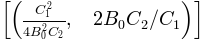

In [11]:
sol = sym.solve([C1_eq, C2_eq], [k_1, k_2])
sol

In [12]:
force_eq = sym.Eq(F_x, (sym.S(3)/4)*C_2*I_hat**2 + (sym.S(3)/2)*C_1*I_hat)
force_eq

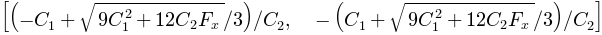

In [13]:
I_hat_solution = sym.solve(force_eq, I_hat)
I_hat_solution

There are two solutions as we would expect because it is a quadratic equation. We can substitute the theoretical values of $C_1$ and $C_2$ into this expression and convert it to a function to obtain $\hat{I}$ as a function of $F_x$.

In [14]:
I_hat_solution_1 = [solution.subs({C_1: C1_theory, C_2: C2_theory}) for solution in I_hat_solution]
I_hat_func = sym.lambdify([F_x], I_hat_solution_1)

Substituting the maximum x-direction force into the function gives us the maximum allowable value of $\hat{I}$.

In [15]:
I_hat_max = I_hat_func(fmax)
I_hat_max

The first solution makes more sense as it will produce less losses (note that the second solution will likely cause saturation as well). We will round this answer and use it as the upper limit for our experiment.

In [16]:
Ihat_resolution = 0.05 #amps
Ihat = np.arange(0, I_hat_max[0].round(2), Ihat_resolution)
fit_values = pd.DataFrame(data = np.vstack( (Ihat, np.round(-Ihat/2, 4)) ).transpose(), 
                          columns = ['$i_1$ = $\hat{I}$', '$i_2$ = $i_3$ = $\\frac{-\hat{I}}{2}$'])
fit_values.head()

,$i_1$ = $\hat{I}$,$i_2$ = $i_3$ = $\frac{-\hat{I}}{2}$
0,0.00,-0.000
1,0.05,-0.025
2,0.10,-0.050
3,0.15,-0.075
4,0.20,-0.100


### Table of Currents for Radial Stage Characterization:

We can add the expected forces to this table as well. To do this, it will be convenient to construct the following function:

In [17]:
def radial_fit(I_hat, C2, C1):
    return 0.75*C2*I_hat**2 + 1.5*C1*I_hat

In [18]:
force_expected = radial_fit(Ihat, C2_theory, C1_theory).round(1)
try:
    fit_values.insert(column = 'Expected Force [N]', loc = 0, value = force_expected)
except:
    fit_values['Expected Force [N]'] = force_expected
fit_values

,Expected Force [N],$i_1$ = $\hat{I}$,$i_2$ = $i_3$ = $\frac{-\hat{I}}{2}$
0,0.0,0.00,-0.000
1,13.3,0.05,-0.025
2,26.7,0.10,-0.050
3,40.3,0.15,-0.075
4,54.1,0.20,-0.100
5,68.1,0.25,-0.125
6,82.3,0.30,-0.150
7,96.6,0.35,-0.175
8,111.2,0.40,-0.200
9,125.9,0.45,-0.225


### Collecting the Data:

At this point we know what data we want to collect and now we will automate the collection process. First we import a few external scripts.

In [19]:
from AMDC import AMDC #AMDC is a class that provides serial communication to AMDC
from Cramb_Control import CRAMB #CRAMB is a class that contains and amdc object and
                                #provides some high level abstractions for commanding
                                #the cramb

The command_que function requires a user-made callable execute object that can be called to execute a command. Below we will create this simple class.

In [20]:
class ExecuteRadialFit():
    
    def __init__(self, cramb_obj):
        
        self.cramb = cramb_obj
    
    def __call__(self, cmd, cmd_cnt):
        
        #cmd is a tuple of (I1, I2)
        self.cramb.currents(*cmd)
        
    def quit(self):
        self.cramb.zero()
        self.cramb.a_zero()

We will use a common naming convention for the data files so that it will be easier to read them in and process them in a structured manner. The convention will be as follows:

for $\hat{I}$ = 1.20:

file name = `radial_fit_1p20.txt`

It would be useful to create a function that generates these file names given a value of $\hat{I}$

In [21]:
def gen_file_name( Ihat, subdir = None ):
    
    #if subdir is left as None, this function will
    #just return the file name. Otherwise it will append 
    #subdir to the file name to create a full path
    
    Ihat_str = f'{Ihat:.2f}'
    Ihat_str = Ihat_str.replace('.', 'p')
    
    file_name = 'radial_fit_' + Ihat_str + '.txt'
    
    if subdir:
        path = subdir / file_name
        
    else:
        path = file_name
        
    return path
    

Let's test our function to make sure it generates a file path correctly.

In [22]:
test = gen_file_name(1.4, subdir = Path('raw_data'))
test

WindowsPath('raw_data/radial_fit_1p40.txt')

Now we can create a list commands and info for each command to execute in a que. The commands will just include of a tuple of $\hat{I}$ and $\hat{I}/2$. The info list will just contain the filename that each data recording should be saved as.

In [23]:
cmds = []
info = []

for idx, row in fit_values.iterrows():
    
    i_hat = row['$i_1$ = $\hat{I}$']
    i_hat2 = row['$i_2$ = $i_3$ = $\\frac{-\hat{I}}{2}$']
    cmd = (i_hat, i_hat2)
    cmds.append(cmd)

    #create info list
    fname = gen_file_name(i_hat)
    info.append(fname)

The following code snippet is what actually outputs the currents to the CRAMB

In [24]:
dc_bus = 30 #volts
R = 10 #ohms
L = 0.0075 #Henry
fb = 300 #Hz (bandwidth of current controller)
radial_inverter = 6

In [25]:
collect_data = True

In [26]:
if collect_data:
    try:
        cramb.disconnect() #disconnect cramb if this cell has already been run
    except:
        pass

    port = "COM4"
    amdc = AMDC(port, cmdEcho = False) #create amdc object
    cramb = CRAMB(amdc) #create cramb object, which has an amdc

    cramb.set_vdc(dc_bus)
    cramb.set_inverter(radial_inverter)
    cramb.set_cc_gains(R = R, L = L, fb = fb)

In [27]:
if collect_data:
    cramb.cc_on()
    ex_rad_fit = ExecuteRadialFit(cramb_obj = cramb)
    ec.command_que(cmds = cmds, execute_obj = ex_rad_fit, info = info)
    cramb.disconnect() #disconnect cramb serial communication after experiment

####################  START  #####################
Info: radial_fit_0p00.txt
Current Command: (0.0, -0.0)



Enter a command:  e


Executed
##################################################
Info: radial_fit_0p05.txt
Current Command: (0.05, -0.025)



Enter a command:  e


Executed
##################################################
Info: radial_fit_0p10.txt
Current Command: (0.1, -0.05)



Enter a command:  e


Executed
##################################################
Info: radial_fit_0p15.txt
Current Command: (0.15000000000000002, -0.075)



Enter a command:  e


Executed
##################################################
Info: radial_fit_0p20.txt
Current Command: (0.2, -0.1)



Enter a command:  e


Executed
##################################################
Info: radial_fit_0p25.txt
Current Command: (0.25, -0.125)



Enter a command:  e


Executed
##################################################
Info: radial_fit_0p30.txt
Current Command: (0.30000000000000004, -0.15)



Enter a command:  e


Executed
##################################################
Info: radial_fit_0p35.txt
Current Command: (0.35000000000000003, -0.175)



Enter a command:  e


Executed
##################################################
Info: radial_fit_0p40.txt
Current Command: (0.4, -0.2)



Enter a command:  e


Executed
##################################################
Info: radial_fit_0p45.txt
Current Command: (0.45, -0.225)



Enter a command:  e


Executed
##################################################
Info: radial_fit_0p50.txt
Current Command: (0.5, -0.25)



Enter a command:  e


Executed
##################################################
Info: radial_fit_0p55.txt
Current Command: (0.55, -0.275)



Enter a command:  e


Executed
##################################################
Info: radial_fit_0p60.txt
Current Command: (0.6000000000000001, -0.3)



Enter a command:  e


Executed
##################################################
Info: radial_fit_0p65.txt
Current Command: (0.65, -0.325)



Enter a command:  e


Executed
##################################################
Info: radial_fit_0p70.txt
Current Command: (0.7000000000000001, -0.35)



Enter a command:  e


Executed
##################################################
Info: radial_fit_0p75.txt
Current Command: (0.75, -0.375)



Enter a command:  e


Executed
##################################################
Info: radial_fit_0p80.txt
Current Command: (0.8, -0.4)



Enter a command:  e


Executed
##################################################
Info: radial_fit_0p85.txt
Current Command: (0.8500000000000001, -0.425)



Enter a command:  e


Executed
##################################################
Info: radial_fit_0p90.txt
Current Command: (0.9, -0.45)



Enter a command:  e


Executed
##################################################
Info: radial_fit_0p95.txt
Current Command: (0.9500000000000001, -0.475)



Enter a command:  e


Executed
##################################################
Info: radial_fit_1p00.txt
Current Command: (1.0, -0.5)



Enter a command:  e


Executed
##################################################
Info: radial_fit_1p05.txt
Current Command: (1.05, -0.525)



Enter a command:  e


Executed
##################################################
Info: radial_fit_1p10.txt
Current Command: (1.1, -0.55)



Enter a command:  e


Executed
##################################################
Info: radial_fit_1p15.txt
Current Command: (1.1500000000000001, -0.575)



Enter a command:  e


Executed
##################################################
Info: radial_fit_1p20.txt
Current Command: (1.2000000000000002, -0.6)



Enter a command:  e


Executed
##################################################
Info: radial_fit_1p25.txt
Current Command: (1.25, -0.625)



Enter a command:  e


Executed
##################################################
Info: radial_fit_1p30.txt
Current Command: (1.3, -0.65)



Enter a command:  e


Executed
#####################  End  ######################
Info: radial_fit_1p35.txt
Current Command: (1.35, -0.675)



Enter a command:  e


Executed
#####################  End  ######################
Info: radial_fit_1p35.txt
Current Command: (1.35, -0.675)



Enter a command:  e


Executed
#####################  End  ######################
Info: radial_fit_1p35.txt
Current Command: (1.35, -0.675)



Enter a command:  q


#####################  DONE  #####################

Done with all commands!



### Cleaning the Data:

The experimentally measured data does not come in a form that's useable immediately so we must process it first.

Each data point corresponds to its own file. Within each file there are a large number of samples taken over a window of time. We don't expect there to be any time dependence for our static load testing so we can just read each file and average every measured quantity over the entire window period.

After the header information at the top of the text file, the columns are in the following order:

`time, My, Fz, Fx, Fy, Mx, Mz`

Now we can create a data frame that we can append all of the data to. Note that the column names are in a different order than the data that is being read in; this is fine because Pandas automatically appends data based on the data's indices.

In [28]:
columns = ['$\hat{I}$', 'Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']
radial_fit_data = pd.DataFrame(columns = columns)
radial_fit_data

,$\hat{I}$,Fx,Fy,Fz,Mx,My,Mz


In [29]:
for current in Ihat: #loop over all values of Ihat
    
    path = gen_file_name(current, raw_path_1) #generate file name
    data = ec.extract_averages(path) #extract data from file into pandas series
    data *= -1 #data is force on stator, we want force on rotor, which is
               #equal and opposite in magnitude
    data['$\hat{I}$'] = current #add Ihat information to load cell data
    
    #append individual data point to pandas dataframe
    radial_fit_data = radial_fit_data.append(data, sort = False, ignore_index = True) #the index is the name of the series; we are not
    #giving a name to the series so all of the indices will be zero, we can avoid this by setting 
    #ignore_index = True set sort to False so that the order of the columns of the original dataframe is 
    #maintained even though the series that are being appended have a different ordering

radial_fit_data #display the dataframe

,$\hat{I}$,Fx,Fy,Fz,Mx,My,Mz
0,0.00,203.993567,11.852122,-222.632111,144.297556,-9.446497,0.281332
1,0.05,203.993567,11.852122,-222.632111,144.297556,-9.446497,0.281332
2,0.10,203.993567,11.852122,-222.632111,144.297556,-9.446497,0.281332
3,0.15,203.993567,11.852122,-222.632111,144.297556,-9.446497,0.281332
4,0.20,203.993567,11.852122,-222.632111,144.297556,-9.446497,0.281332
5,0.25,203.993567,11.852122,-222.632111,144.297556,-9.446497,0.281332
6,0.30,203.993567,11.852122,-222.632111,144.297556,-9.446497,0.281332
7,0.35,203.993567,11.852122,-222.632111,144.297556,-9.446497,0.281332
8,0.40,203.993567,11.852122,-222.632111,144.297556,-9.446497,0.281332
9,0.45,203.993567,11.852122,-222.632111,144.297556,-9.446497,0.281332


Now that we've gota all of the data into a nice format, we can save it so that the processed data persists.

In [30]:
processed_fname = 'radial_fit_data.csv'
processed_fpath = processed_path / processed_fname
radial_fit_data.to_csv(processed_fpath)

### Fitting the Data

The function `radial_fit` created above represents the relationship between the input current $\hat{I}$ and the force in the x direction, $F_x$. Accordingly, this is the function that will be fit to the experimental data.

In [31]:
opt_params, _ = opt.curve_fit(radial_fit, xdata = Ihat, ydata = radial_fit_data['Fx'], p0 = [C2_theory, C1_theory])
opt_params

array([-479.28003612,  395.40603068])

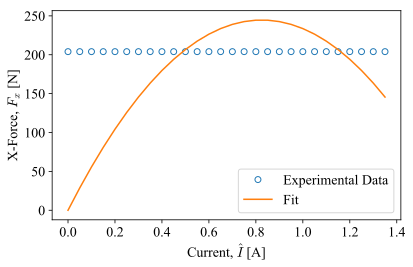

In [32]:
plt.close('all')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Current, $\hat{I}$ [A]')
ax.set_ylabel('X-Force, $F_x$ [N]')
ax.tick_params(labelsize = 14)
ax.plot( Ihat, radial_fit_data['Fx'], marker = 'o', mfc = 'none', ls = '', label = 'Experimental Data')
ax.plot( Ihat, radial_fit(Ihat, opt_params[0], opt_params[1]), label = 'Fit')
ax.legend()
fig.tight_layout()
